# 一致预期计算schedule表， 只加载需要计算的ticker的数据

# 批量计算所有 ticker

In [1]:

from datetime import datetime, timedelta
ticker='000002'
pred_date = datetime.today().date()
# pred_date='2019-05-27'
pred_date=datetime(2019,5,27).date()

In [1]:

class MysqlConn(object):
    def __init__(self, config_json_str):
        # self.mysql_config = {"host": "10.22.128.150",  "port": 3317, "db": "bigdata", "user": "talend_load",
        #   "passwd": "s9t5gNThn2vqWM7c" , "charset" : "utf8"}
        # self.mysql_config = {"host": "db-bigdata.wmcloud-qa.com",  "port": 3312, "db": "bigdata", "user": "app_bigdata_ro",
        #   "passwd": "Welcome_20141217"}
        self.mysql_config = json.loads(config_json_str, encoding='utf-8')

    def connect(self):
        mysql_conn = pymysql.connect(**self.mysql_config)
        return mysql_conn

class MssqlConn(object):
    def __init__(self, config_json_str):
        # self.mssql_config = {"server": "sh-datayesdb.wmcloud-dev.com",  "port": 1433, "database": "datayesdb",
        #     "user": "talend_load", "password": "Welcome01"}
        self.mssql_config = json.loads(config_json_str, encoding='utf-8')

    def connect(self):
        mssql_conn = pymssql.connect(**self.mssql_config)
        return mssql_conn

    def __str__(self):
        return json.dumps(self.mssql_config, ensure_ascii=False, encoding='utf-8')



In [3]:
import json
import pymysql
import pymssql
# MySQL
bigdata={"host":"security03-dev.datayes.com","port":3306,"user":"talend_load","passwd":"NCph1G9BQT3DuQj","db":"bigdata","charset":"utf8"}
dateyesdbp={"host":"db-datayesdb-ro.wmcloud.com","port":3313,"user":"app_dataqa_ro","passwd":"Welcome20140820","db":"datayesdbp","charset":"utf8"}
datayesdb={"host":"db-datayesdb-ro.wmcloud.com","port":3313,"database":"datayesdb","user":"app_gaea_ro","password":"EQw6WquhnCKPp8Li","charset":"utf8"}

# researchrpt={"host":"db-researchrpt-ro.wmcloud.com","port":3306,"user":"app_gaea_ro","passwd":"UDVVkvULzakP2048","db":"research_rpt","charset":"utf8"}
# dev
# researchrpt={"host":"10.24.21.34","port":3306,"user":"app_researchrep","passwd":"dG8pqlk5VKOMvDH","db":"research_rpt","charset":"utf8","autocommit":True}
# stg
# researchrpt={"host":"db-researchrpt.wmcloud-stg.com","port":3313,"user":"app_resrpt_rw","passwd":"Wy8tw53XpQfRSukb","db":"research_rpt","charset":"utf8","autocommit":True}
# prd
researchrpt={"host":"db-researchrpt.wmcloud.com","port":3306,"user":"app_researchrep","passwd":"dG8pqlk5VKOMvDH","db":"research_rpt","charset":"utf8","autocommit":True}


# datayesdb_conn = MysqlConn(json.dumps(datayesdb)).connect()
researchrpt_conn = MysqlConn(json.dumps(researchrpt)).connect()

# datayes_conn = MssqlConn(json.dumps(datayes)).connect()


In [4]:
import pandas as pd
import numpy as np

### load data

In [5]:
org_predict_tpas = pd.read_csv("org_predict_tpas.csv", index_col=0, dtype={"ticker_symbol": str})
org_predict_tpas.head()

c:\python27\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,report_search_id,ticker_symbol,organ_id,create_date,into_date,time_year,forecast_income,forecast_profit,forecast_eps,org_name,org_remark1
0,100258238,NaN,109,2018-12-31,2019-01-02 00:00:00,2018,3.830000e+09,NaN,NaN,国金证券,1
1,100258238,NaN,109,2018-12-31,2019-01-02 00:00:00,2019,4.540000e+09,NaN,NaN,国金证券,1
2,100258238,NaN,109,2018-12-31,2019-01-02 00:00:00,2020,5.480000e+09,NaN,NaN,国金证券,1
3,100241952,NaN,2570,2019-01-02,2019-01-03 00:00:00,2018,NaN,190000000.0,NaN,天风证券,1
4,100241952,NaN,2570,2019-01-02,2019-01-03 00:00:00,2019,NaN,180000000.0,NaN,天风证券,1


In [6]:
org_predict_tpas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1044114 entries, 0 to 1044113
Data columns (total 11 columns):
report_search_id    1044114 non-null int64
ticker_symbol       1044047 non-null object
organ_id            1044114 non-null int64
create_date         1044114 non-null object
into_date           1044114 non-null object
time_year           1044114 non-null int64
forecast_income     427409 non-null float64
forecast_profit     572442 non-null float64
forecast_eps        1013195 non-null float64
org_name            1044114 non-null object
org_remark1         1044114 non-null int64
dtypes: float64(3), int64(4), object(4)
memory usage: 95.6+ MB


In [7]:
tprice_and_score = pd.read_csv("tprice_and_score.csv", index_col=0, dtype={"ticker_symbol": str})
tprice_and_score = tprice_and_score.dropna(subset=['ticker_symbol'])
tprice_and_score['ticker_symbol'] = tprice_and_score['ticker_symbol'].astype('str')
org_predict_tpas = pd.read_csv("org_predict_tpas.csv", index_col=0, dtype={"ticker_symbol": str})

true = pd.read_csv("true.csv", index_col=0, dtype={"ticker_symbol": str})


In [413]:
tprice_and_score.info()
# cmb_report_research_m 共119万数据， 大于16年的数据共51万。

<class 'pandas.core.frame.DataFrame'>
Int64Index: 430323 entries, 42 to 430364
Data columns (total 6 columns):
report_search_id    430323 non-null int64
ticker_symbol       430323 non-null object
organ_id            430320 non-null float64
create_date         430323 non-null object
target_price        77016 non-null float64
score               310131 non-null float64
dtypes: float64(3), int64(1), object(2)
memory usage: 23.0+ MB


In [820]:
tprice_and_score[tprice_and_score.ticker_symbol==ticker].info()
# cmb_report_research_m 共119万数据， 大于16年的数据共51万。

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1043 entries, 590 to 1632
Data columns (total 6 columns):
report_search_id    1043 non-null int64
ticker_symbol       1043 non-null object
organ_id            1043 non-null float64
create_date         1043 non-null datetime64[ns]
target_price        233 non-null float64
score               971 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 57.0+ KB


In [414]:
tprice_and_score.ticker_symbol.unique()

array(['000001', '000002', '000004', ..., 'A19105', 'A19112', 'DY18028E'],
      dtype=object)

In [144]:
tprice_and_score.head()

,report_search_id,ticker_symbol,organ_id,create_date,target_price,score
42,826638,000001,61.0,2016-09-07,NaN,0.75
43,827140,000001,9.0,2016-09-12,10.4,0.75
44,831604,000001,24.0,2016-10-10,NaN,NaN
45,833186,000001,41.0,2016-10-10,NaN,0.75
46,833098,000001,45.0,2016-10-13,9.4,0.50


In [819]:
tprice_and_score.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 430323 entries, 42 to 430364
Data columns (total 6 columns):
report_search_id    430323 non-null int64
ticker_symbol       430323 non-null object
organ_id            430320 non-null float64
create_date         430323 non-null datetime64[ns]
target_price        77016 non-null float64
score               310131 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 23.0+ MB


In [417]:
### primary key: ticker_symbol, organ_id, creaete_date
org_predict.head()

,report_search_id,ticker_symbol,organ_id,create_date,into_date,time_year,forecast_income,forecast_profit,forecast_eps,org_name,org_remark1
0,1169249,000001,9,2016-09-12,2016-09-12 15:55:00,2016.0,NaN,NaN,1.36,海通证券,1.0
1,1169249,000001,9,2016-09-12,2016-09-12 15:55:00,2017.0,NaN,NaN,1.43,海通证券,1.0
2,1173133,000001,45,2016-10-13,2016-10-14 15:25:34,2016.0,1.096580e+11,2.379500e+10,1.39,UBS,1.0
3,1173133,000001,45,2016-10-13,2016-10-14 15:25:34,2017.0,1.194020e+11,2.447400e+10,1.43,UBS,1.0
4,1173133,000001,45,2016-10-13,2016-10-14 15:25:34,2018.0,1.303380e+11,2.538500e+10,1.48,UBS,1.0


In [418]:
true.head(1)

,ticker_symbol,act_pubtime,publish_date,end_date_rep,time_year,income_true,profit_true,eps_true
0,000001,2001-04-13 18:00:00,2001-04-14,2000-12-31,2000,2.789163e+09,506551785.0,NaN


In [419]:
tickers=pd.read_csv("tickers.csv", index_col=0, dtype={"ticker_symbol":str})

In [420]:
tickers.head(1)

,ticker_symbol,list_date,delist_date,SEC_SHORT_NAME
0,000001,1991-04-03,NaN,平安银行


### TODO to filter tickers in A


In [16]:
# all_year_error_dict={}

# 目标价 target_price

In [8]:

def get_period_data(data, start_date, end_date):
    """
    获取某一时间段内的数据
    """
    # if 'create_date' not in data.columns:
    #     return pd.DataFrame()
    data['create_date'] = pd.to_datetime(data['create_date'])
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    if start_date is None and end_date is None:
        period_data = data.reset_index().drop('index', axis=1)
    elif start_date is not None and end_date is None:
        period_data = data[data['create_date'] >= start_date].reset_index().drop('index', axis=1)
    elif start_date is None and end_date is not None:
        period_data = data[data['create_date'] <= end_date].reset_index().drop('index', axis=1)
    else:
        period_data = data[
            (data['create_date'] >= start_date) & (data['create_date'] <= end_date)].reset_index().drop('index',
                                                                                                        axis=1)
    return period_data


### tprice_and_score

In [512]:
#  str(pred_date)

'2019-05-27'

In [833]:
# 筛选90天数据
price_df = get_period_data(tprice_and_score, str(pred_date - timedelta(90)), str(pred_date))
# .drop_duplicates(
#     'organ_id', keep='last')

In [834]:
# 去重， 需要去掉的重复的数据为 True

#         df = df.dropna(subset=[self.consensus_name]).sort_values(['organ_id', 'create_date']).drop_duplicates(
#             'organ_id', keep='last')

#  for below steps,  need to deal with nan, it is different for price and score
price_df = price_df.dropna(subset=["target_price"]).sort_values(['organ_id', 'create_date'])
# price_df = price_df.dropna(subset=["target_price", "score"], how='all').sort_values(['organ_id', 'create_date'])
price_df = price_df[~price_df.duplicated(['ticker_symbol', 'organ_id'], keep='last')]

In [831]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1893 entries, 6591 to 13402
Data columns (total 6 columns):
report_search_id    1893 non-null int64
ticker_symbol       1893 non-null object
organ_id            1893 non-null float64
create_date         1893 non-null datetime64[ns]
target_price        1893 non-null float64
score               1892 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 103.5+ KB


In [832]:
price_df[price_df.ticker_symbol==ticker].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 72 to 73
Data columns (total 6 columns):
report_search_id    8 non-null int64
ticker_symbol       8 non-null object
organ_id            8 non-null float64
create_date         8 non-null datetime64[ns]
target_price        8 non-null float64
score               8 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 448.0+ bytes


In [519]:
# price_df
# 按日期筛选后的记录没剩下多少 。 ？？？

In [520]:
# 针对每个ticker， organ_id去重 
# price_df = price_df.drop_duplicates('organ_id', keep='last')
# tmp

In [521]:
# tmp = price_df[price_df.ticker_symbol==ticker].reset_index()
# tmp.duplicated(['ticker_symbol', 'organ_id'], keep='last') # keep = 'last' means false,  to get rows are duplicated

In [522]:
# tmp

,index,report_search_id,ticker_symbol,organ_id,create_date,target_price,score
0,72,2108407,000002,2.0,2019-04-16,43.01,1.00
1,71,2108070,000002,5.0,2019-04-16,39.91,1.00
2,62,2109673,000002,9.0,2019-03-30,33.21,0.75
3,54,2102450,000002,12.0,2019-03-26,33.21,1.00
4,52,2103228,000002,13.0,2019-03-26,37.05,1.00
5,68,2104598,000002,20.0,2019-04-04,35.00,1.00
6,53,2102345,000002,30.0,2019-03-26,34.38,1.00
7,70,2105829,000002,61.0,2019-04-08,39.60,1.00
8,56,2102915,000002,77.0,2019-03-26,32.58,1.00
9,57,2102347,000002,119.0,2019-03-27,41.13,0.75


### org_predict_tpas

In [821]:
org_predict_tpas[org_predict_tpas.ticker_symbol==ticker].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2429 entries, 1376 to 3804
Data columns (total 11 columns):
report_search_id    2429 non-null int64
ticker_symbol       2429 non-null object
organ_id            2429 non-null int64
create_date         2429 non-null datetime64[ns]
into_date           2429 non-null object
time_year           2429 non-null int64
forecast_income     1096 non-null float64
forecast_profit     1245 non-null float64
forecast_eps        2402 non-null float64
org_name            2429 non-null object
org_remark1         2429 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(4), object(3)
memory usage: 227.7+ KB


In [334]:
predict_df = get_period_data(org_predict_tpas, str(pred_date - timedelta(90)), str(pred_date))

In [14]:
predict_df.head(1)

,report_search_id,ticker_symbol,organ_id,create_date,into_date,time_year,forecast_income,forecast_profit,forecast_eps,org_name,org_remark1
0,2099592,000001,3,2019-03-03,2019-03-03 00:00:00,2018,1.167560e+11,2.481600e+10,1.45,中金,1


In [822]:
#         dfmerge = dfmerge.dropna(subset=['time_year'])

predict_df = predict_df.dropna(subset=['time_year'])
predict_df['time_year'] = predict_df['time_year'].astype(int)

In [823]:
predict_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54224 entries, 0 to 54223
Data columns (total 11 columns):
report_search_id    54224 non-null int64
ticker_symbol       54224 non-null object
organ_id            54224 non-null int64
create_date         54224 non-null datetime64[ns]
into_date           54224 non-null object
time_year           54224 non-null int32
forecast_income     52537 non-null float64
forecast_profit     52905 non-null float64
forecast_eps        53657 non-null float64
org_name            54224 non-null object
org_remark1         54224 non-null int64
dtypes: datetime64[ns](1), float64(3), int32(1), int64(3), object(3)
memory usage: 4.8+ MB


In [530]:
predict_df[predict_df.ticker_symbol==ticker].reset_index().info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 12 columns):
index               158 non-null int64
report_search_id    158 non-null int64
ticker_symbol       158 non-null object
organ_id            158 non-null int64
create_date         158 non-null datetime64[ns]
into_date           158 non-null object
time_year           158 non-null int32
forecast_income     149 non-null float64
forecast_profit     146 non-null float64
forecast_eps        157 non-null float64
org_name            158 non-null object
org_remark1         158 non-null int64
dtypes: datetime64[ns](1), float64(3), int32(1), int64(4), object(3)
memory usage: 14.3+ KB


### 机构预测误差

In [ ]:
#         if self.all_year_error_dict.get(self.ticker) is None:


In [23]:
#  done
def get_year_error(predict_org):
#     year = predict_org.time_year.unique()
#     true = true[true['time_year'] == year].reset_index().drop('index', axis=1)
    # 这一年度有哪些机构作了预测
    predict_org = predict_org.sort_values(by='create_date').drop_duplicates(
        subset=['organ_id', 'create_date'],
        keep='last').reset_index().drop(
        'index',
        axis=1)
    predict_org['income_true'] = predict_org.income_true.astype(float)
    predict_org['eps_true'] = predict_org.eps_true.astype(float)
    predict_org['forecast_income'] = predict_org.forecast_income.astype(float)
    predict_org['forecast_profit'] = predict_org.forecast_profit.astype(float)
    predict_org['forecast_eps'] = predict_org.forecast_eps.astype(float)
    if len(predict_org) > 0:
        predict_org['income_err'] = ((predict_org.ix[0, 'income_true'] - predict_org['forecast_income']) / predict_org.ix[
            0, 'income_true']) ** 2
        predict_org['profit_err'] = ((predict_org.ix[0, 'profit_true'] - predict_org['forecast_profit']) / predict_org.ix[
            0, 'profit_true']) ** 2
        predict_org['eps_err'] = ((predict_org.ix[0, 'eps_true'] - predict_org['forecast_eps']) / predict_org.ix[
            0, 'eps_true']) ** 2
#         predict_org['time_year'] = year
        return predict_org[['organ_id', 'income_err', 'profit_err', 'eps_err']]


In [162]:
# 先合并 org_predict , true
org_true = org_predict_tpas[["ticker_symbol","organ_id","create_date",'time_year','forecast_income','forecast_profit','forecast_eps']].merge(true[["ticker_symbol",'time_year','income_true', 'profit_true','eps_true']], on=["ticker_symbol",'time_year'])

In [47]:
org_true.head(10)

,ticker_symbol,organ_id,create_date,time_year,forecast_income,forecast_profit,forecast_eps,income_true,profit_true,eps_true
0,000001,61,2016-09-07,2016,NaN,2.334700e+10,1.359723,1.077150e+11,2.259900e+10,1.32
1,000001,9,2016-09-12,2016,NaN,NaN,1.360000,1.077150e+11,2.259900e+10,1.32
2,000001,24,2016-10-10,2016,NaN,2.386687e+10,1.390000,1.077150e+11,2.259900e+10,1.32
3,000001,41,2016-10-10,2016,NaN,2.403858e+10,1.400000,1.077150e+11,2.259900e+10,1.32
4,000001,45,2016-10-13,2016,1.096580e+11,2.379500e+10,1.390000,1.077150e+11,2.259900e+10,1.32
5,000001,109,2016-10-20,2016,1.128610e+11,2.329600e+10,1.360000,1.077150e+11,2.259900e+10,1.32
6,000001,7,2016-10-20,2016,NaN,2.310000e+10,1.340000,1.077150e+11,2.259900e+10,1.32
7,000001,3,2016-10-20,2016,1.125680e+11,2.351900e+10,1.370000,1.077150e+11,2.259900e+10,1.32
8,000001,26,2016-10-20,2016,1.099550e+11,2.303000e+10,1.340000,1.077150e+11,2.259900e+10,1.32
9,000001,13,2016-10-21,2016,1.047750e+11,2.345400e+10,1.370000,1.077150e+11,2.259900e+10,1.32


In [48]:
org_true.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 599185 entries, 0 to 599184
Data columns (total 10 columns):
ticker_symbol      599185 non-null object
organ_id           599185 non-null int64
create_date        599185 non-null datetime64[ns]
time_year          599185 non-null int64
forecast_income    217813 non-null float64
forecast_profit    334491 non-null float64
forecast_eps       583951 non-null float64
income_true        599185 non-null float64
profit_true        599185 non-null float64
eps_true           598938 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(2), object(1)
memory usage: 50.3+ MB


In [163]:
# group by ticker , time_year 
org_error_df = org_true.groupby(["ticker_symbol", "time_year"]).apply(get_year_error)

c:\python27\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [164]:
org_error_df = org_error_df.reset_index()

In [618]:
# year_error_df = year_error_df.drop('level_2', axis=1)
org_error_df[org_error_df.ticker_symbol==ticker].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 695 to 2032
Data columns (total 7 columns):
ticker_symbol    1338 non-null object
time_year        1338 non-null int64
level_2          1338 non-null int64
organ_id         1338 non-null int64
income_err       545 non-null float64
profit_err       662 non-null float64
eps_err          1320 non-null float64
dtypes: float64(3), int64(3), object(1)
memory usage: 83.6+ KB


In [57]:
# 挑出预测不准的？？？
# if all_year_error_dict.get(ticker) is None:
#     all_year_error_dict[ticker] = get_all_year_error(org_predict_tpas, true)
#     all_year_error = all_year_error_dict.get(ticker)
# else:zzz
#     all_year_error = all_year_error_dict.get(ticker)


### 取time_year  year_list

In [336]:
# drop duplicate for each ticker, time_year
#         year_list = dfmerge.drop_duplicates('time_year', keep='last').sort_values(by='time_year').reset_index().drop(

year_list = predict_df[~predict_df.duplicated(['ticker_symbol','time_year'], keep='last')]
# year_list = predict_df.drop_duplicates('time_year', keep='last').sort_values(by='time_year').reset_index().drop(
#     'index', axis=1)

In [399]:
year_list[year_list.ticker_symbol==ticker]

,report_search_id,ticker_symbol,organ_id,create_date,into_date,time_year,forecast_income,forecast_profit,forecast_eps,org_name,org_remark1
197,2114284,000002,2570,2019-04-30,2019-04-30 00:00:00,2018,NaN,NaN,NaN,天风证券,1
240,2119019,000002,118,2019-05-26,2019-05-26 00:00:00,2019,3.592512e+11,3.910910e+10,3.54,中泰证券,1
241,2119019,000002,118,2019-05-26,2019-05-26 00:00:00,2020,4.425022e+11,4.539274e+10,4.11,中泰证券,1
242,2119019,000002,118,2019-05-26,2019-05-26 00:00:00,2021,5.496804e+11,5.287525e+10,4.79,中泰证券,1


### true

In [26]:
true.head(1)

,ticker_symbol,act_pubtime,publish_date,end_date_rep,time_year,income_true,profit_true,eps_true
0,000001,2001-04-13 18:00:00,2001-04-14,2000-12-31,2000,2.789163e+09,506551785.0,NaN


In [27]:
# true[['ticker_symbol', 'act_pubtime', 'time_year']].reset_index().drop('index', axis=1)

In [400]:
#         new_pubdate = self.true[['ticker_symbol', 'act_pubtime', 'time_year']].reset_index().drop('index', axis=1)

new_pubdate = true[['ticker_symbol', 'act_pubtime', 'time_year']].reset_index().drop('index', axis=1)
new_pubdate.head(1)



,ticker_symbol,act_pubtime,time_year
0,000001,2001-04-13 18:00:00,2000


In [19]:
# new_pubdate[new_pubdate.ticker_symbol=='000002'].reset_index()

In [401]:
#             year_list.apply(lambda x: consensus.check_already_publish_report(x, new_pubdate), axis=1)]

year_list_filter = year_list.merge(new_pubdate[['ticker_symbol','time_year','act_pubtime']], on=['ticker_symbol','time_year'], how='left')

In [403]:
# 考查time year, 将实际发布日期小于当前预测日期的记录从year list里移除
year_list_filter = year_list_filter[~(year_list_filter.act_pubtime < str(pred_date))]
year_list_filter = year_list_filter.drop('act_pubtime',axis=1)

In [404]:
year_list_filter[year_list_filter.ticker_symbol==ticker]

,report_search_id,ticker_symbol,organ_id,create_date,into_date,time_year,forecast_income,forecast_profit,forecast_eps,org_name,org_remark1
5,2119019,000002,118,2019-05-26,2019-05-26 00:00:00,2019,3.592512e+11,3.910910e+10,3.54,中泰证券,1
6,2119019,000002,118,2019-05-26,2019-05-26 00:00:00,2020,4.425022e+11,4.539274e+10,4.11,中泰证券,1
7,2119019,000002,118,2019-05-26,2019-05-26 00:00:00,2021,5.496804e+11,5.287525e+10,4.79,中泰证券,1


### if not (len(df) == 0 and len(dfmerge) == 0):
            dfmerge = dfmerge.merge(

In [467]:
# 从 org predict 中去掉price_and_score中没有的数据
#     dfmerge = dfmerge.merge(
#                 df[['report_search_id', 'ticker_symbol', 'organ_id', 'create_date', self.consensus_name]],
#                 on=['report_search_id', 'ticker_symbol', 'organ_id', 'create_date'], how='right')
        
dfmerge = predict_df.merge(
    price_df[['report_search_id', 'ticker_symbol', 'organ_id', 'create_date', 'target_price','score']],
    on=['report_search_id', 'ticker_symbol', 'organ_id', 'create_date'], how='right')

In [472]:
# TODO, here if dropna is needed
#         if len(dfmerge['time_year'].dropna()) > 0:
# 
# dfmerge.dropna(subset=['time_year'],axis=1)

In [468]:
dfmerge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33704 entries, 0 to 33703
Data columns (total 13 columns):
report_search_id    33704 non-null int64
ticker_symbol       33704 non-null object
organ_id            33704 non-null float64
create_date         33704 non-null datetime64[ns]
into_date           33102 non-null object
time_year           33102 non-null float64
forecast_income     32369 non-null float64
forecast_profit     32619 non-null float64
forecast_eps        32802 non-null float64
org_name            33102 non-null object
org_remark1         33102 non-null float64
target_price        5479 non-null float64
score               33701 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(1), object(3)
memory usage: 3.6+ MB


In [814]:
dfmerge[dfmerge.ticker_symbol==ticker].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 46 to 33149
Data columns (total 13 columns):
report_search_id    75 non-null int64
ticker_symbol       75 non-null object
organ_id            75 non-null float64
create_date         75 non-null datetime64[ns]
into_date           74 non-null object
time_year           74 non-null float64
forecast_income     71 non-null float64
forecast_profit     71 non-null float64
forecast_eps        73 non-null float64
org_name            74 non-null object
org_remark1         74 non-null float64
target_price        24 non-null float64
score               75 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(1), object(3)
memory usage: 8.2+ KB


In [406]:
dfmerge.head()

,report_search_id,ticker_symbol,organ_id,create_date,into_date,time_year,forecast_income,forecast_profit,forecast_eps,org_name,org_remark1,target_price,score
0,2099227,000001,138.0,2019-03-07,2019-03-07 00:00:00,2019.0,1.344000e+11,2.720000e+10,1.53,民生证券,1.0,NaN,0.75
1,2099227,000001,138.0,2019-03-07,2019-03-07 00:00:00,2020.0,1.488000e+11,2.930000e+10,1.66,民生证券,1.0,NaN,0.75
2,2099227,000001,138.0,2019-03-07,2019-03-07 00:00:00,2021.0,1.613000e+11,3.160000e+10,1.79,民生证券,1.0,NaN,0.75
3,2110748,000001,61.0,2019-04-23,2019-04-24 00:00:00,2019.0,1.281590e+11,2.648200e+10,1.49,广发证券,1.0,17.06,1.00
4,2110748,000001,61.0,2019-04-23,2019-04-24 00:00:00,2020.0,1.418820e+11,2.880400e+10,1.63,广发证券,1.0,17.06,1.00


In [813]:
dfmerge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33704 entries, 0 to 33703
Data columns (total 13 columns):
report_search_id    33704 non-null int64
ticker_symbol       33704 non-null object
organ_id            33704 non-null float64
create_date         33704 non-null datetime64[ns]
into_date           33102 non-null object
time_year           33102 non-null float64
forecast_income     32369 non-null float64
forecast_profit     32619 non-null float64
forecast_eps        32802 non-null float64
org_name            33102 non-null object
org_remark1         33102 non-null float64
target_price        5479 non-null float64
score               33701 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(1), object(3)
memory usage: 4.8+ MB


In [56]:
# con_expec = pd.DataFrame(
#             columns=['code', 'pred_date', 'con_' + 'target_price', 'con_type_' + 'target_price'],
#             index=range(1))

### if len(dfmerge['time_year'].dropna()) > 0:

In [579]:
# ticker

'000002'

In [407]:
year_error_df.head()

,ticker_symbol,time_year,level_2,organ_id,income_err,profit_err,eps_err,year_min
0,000001,2015,0,20,NaN,NaN,0.000370,2019.0
1,000001,2016,0,61,NaN,0.001096,0.000906,2019.0
2,000001,2016,1,9,NaN,NaN,0.000918,2019.0
3,000001,2016,2,24,NaN,0.003148,0.002812,2019.0
4,000001,2016,3,41,NaN,0.004058,0.003673,2019.0


In [409]:
year_error_df[year_error_df.ticker_symbol==ticker].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 695 to 2032
Data columns (total 8 columns):
ticker_symbol    1338 non-null object
time_year        1338 non-null int64
level_2          1338 non-null int64
organ_id         1338 non-null int64
income_err       545 non-null float64
profit_err       662 non-null float64
eps_err          1320 non-null float64
year_min         1338 non-null float64
dtypes: float64(4), int64(3), object(1)
memory usage: 94.1+ KB


In [588]:
year_list.head()

,report_search_id,ticker_symbol,organ_id,create_date,into_date,time_year,forecast_income,forecast_profit,forecast_eps,org_name,org_remark1
61,2110425,000001,20,2019-04-24,2019-04-24 00:00:00,2018,1.167160e+11,2.481800e+10,1.39,中信建投,1
82,2113814,000001,217,2019-05-08,2019-05-08 00:00:00,2019,1.322580e+11,2.759800e+10,1.61,安信证券,1
83,2113814,000001,217,2019-05-08,2019-05-08 00:00:00,2020,1.504000e+11,3.201700e+10,1.86,安信证券,1
84,2113814,000001,217,2019-05-08,2019-05-08 00:00:00,2021,1.701450e+11,3.764200e+10,2.19,安信证券,1
197,2114284,000002,2570,2019-04-30,2019-04-30 00:00:00,2018,NaN,NaN,NaN,天风证券,1


In [589]:
year_list['time_year'].min()

2010

In [587]:
org_error_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584118 entries, 0 to 584117
Data columns (total 7 columns):
ticker_symbol    584118 non-null object
time_year        584118 non-null int64
level_2          584118 non-null int64
organ_id         584118 non-null int64
income_err       214698 non-null float64
profit_err       330622 non-null float64
eps_err          568996 non-null float64
dtypes: float64(3), int64(3), object(1)
memory usage: 31.2+ MB


In [643]:
year_list_filter[year_list_filter.ticker_symbol==ticker].time_year.min()

2019

# 筛选3年的数据

            pred_error = all_year_error[all_year_error['time_year'] >= (year_list['time_year'].min() - 3)]

            pred_error = pred_error[pred_error['time_year'] < year_list['time_year'].min()]

In [767]:
#             pred_error = all_year_error[all_year_error['time_year'] >= (year_list['time_year'].min() - 3)]

df = year_list_filter.groupby('ticker_symbol').apply(lambda x: x['time_year'].min()).to_frame('year_min').reset_index()
year_error_df = org_error_df.merge(df, on='ticker_symbol',how='left')
# pred_error = year_error_df[year_error_df['time_year'] >= (year_list['time_year'].min() - 3)]
# pred_error = pred_error[pred_error['time_year'] < (year_list['time_year'].min())]
# pred_error = pred_error[pred_error['time_year'] < year_list['time_year'].min()]


In [768]:
pred_error = year_error_df[(year_error_df['time_year']>=year_error_df['year_min']-3) & (year_error_df['time_year']<year_error_df['year_min'])]

In [769]:
year_error_df[year_error_df.ticker_symbol==ticker].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 695 to 2032
Data columns (total 8 columns):
ticker_symbol    1338 non-null object
time_year        1338 non-null int64
level_2          1338 non-null int64
organ_id         1338 non-null int64
income_err       545 non-null float64
profit_err       662 non-null float64
eps_err          1320 non-null float64
year_min         1338 non-null float64
dtypes: float64(4), int64(3), object(1)
memory usage: 94.1+ KB


In [770]:
pred_error[pred_error.ticker_symbol==ticker].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 695 to 2032
Data columns (total 8 columns):
ticker_symbol    1338 non-null object
time_year        1338 non-null int64
level_2          1338 non-null int64
organ_id         1338 non-null int64
income_err       545 non-null float64
profit_err       662 non-null float64
eps_err          1320 non-null float64
year_min         1338 non-null float64
dtypes: float64(4), int64(3), object(1)
memory usage: 94.1+ KB


In [473]:
pred_error.head()

,ticker_symbol,time_year,level_2,organ_id,income_err,profit_err,eps_err,year_min
1,000001,2016,0,61,NaN,0.001096,0.000906,2019.0
2,000001,2016,1,9,NaN,NaN,0.000918,2019.0
3,000001,2016,2,24,NaN,0.003148,0.002812,2019.0
4,000001,2016,3,41,NaN,0.004058,0.003673,2019.0
5,000001,2016,4,45,0.000325,0.002801,0.002812,2019.0


# pred_org = consensus.get_org_parameter(dfmerge, pred_error)


### for each ticker and organ, fillna with mean()

In [ ]:
#             pred_org = consensus.get_org_parameter(dfmerge, pred_error)
# TODO for those tickers do not in pred_error, 

In [171]:
dfmerge.head()

,report_search_id,ticker_symbol,organ_id,create_date,into_date,time_year,forecast_income,forecast_profit,forecast_eps,org_name,org_remark1,target_price,score
0,2099096,000001,77.0,2019-03-08,2019-03-08 00:00:00,2019.0,1.295250e+11,2.741200e+10,1.60,华泰证券,1.0,15.70,1.0
1,2099096,000001,77.0,2019-03-08,2019-03-08 00:00:00,2020.0,1.459970e+11,3.081300e+10,1.79,华泰证券,1.0,15.70,1.0
2,2099096,000001,77.0,2019-03-08,2019-03-08 00:00:00,2021.0,1.687430e+11,3.541000e+10,2.06,华泰证券,1.0,15.70,1.0
3,2101297,000001,3.0,2019-03-17,2019-03-17 00:00:00,2019.0,1.301910e+11,2.916500e+10,1.70,中金,1.0,16.52,1.0
4,2101297,000001,3.0,2019-03-17,2019-03-17 00:00:00,2020.0,1.498970e+11,3.515300e+10,2.05,中金,1.0,16.52,1.0


In [812]:
dfmerge[dfmerge.ticker_symbol==ticker].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 46 to 33149
Data columns (total 13 columns):
report_search_id    75 non-null int64
ticker_symbol       75 non-null object
organ_id            75 non-null float64
create_date         75 non-null datetime64[ns]
into_date           74 non-null object
time_year           74 non-null float64
forecast_income     71 non-null float64
forecast_profit     71 non-null float64
forecast_eps        73 non-null float64
org_name            74 non-null object
org_remark1         74 non-null float64
target_price        24 non-null float64
score               75 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(1), object(3)
memory usage: 8.2+ KB


In [ ]:
# get mean for each organ and ticker

In [811]:
# pred_error[pred_error.ticker_symbol==ticker]

In [474]:
pred_error.head()

,ticker_symbol,time_year,level_2,organ_id,income_err,profit_err,eps_err,year_min
1,000001,2016,0,61,NaN,0.001096,0.000906,2019.0
2,000001,2016,1,9,NaN,NaN,0.000918,2019.0
3,000001,2016,2,24,NaN,0.003148,0.002812,2019.0
4,000001,2016,3,41,NaN,0.004058,0.003673,2019.0
5,000001,2016,4,45,0.000325,0.002801,0.002812,2019.0


In [771]:
organ_mean = pred_error[['organ_id', 'ticker_symbol', 'income_err', 'profit_err', 'eps_err']].set_index(['ticker_symbol','organ_id']).groupby(level=(0,1)).mean().reset_index()

In [772]:
# and then fillna with tickers mean
# organ_mean
organ_mean['income_err'] = organ_mean[['income_err','ticker_symbol']].groupby('ticker_symbol').transform(lambda x: x.fillna(x.mean()))

In [773]:
organ_mean['profit_err'] = organ_mean[['profit_err','ticker_symbol']].groupby('ticker_symbol').transform(lambda x: x.fillna(x.mean()))

In [774]:
organ_mean['eps_err'] = organ_mean[['eps_err','ticker_symbol']].groupby('ticker_symbol').transform(lambda x: x.fillna(x.mean()))

In [481]:
organ_mean[organ_mean.eps_err.isnull()]

,ticker_symbol,organ_id,income_err,profit_err,eps_err
31509,603811,2570,NaN,0.000012,NaN


In [480]:
organ_mean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32294 entries, 0 to 32293
Data columns (total 5 columns):
ticker_symbol    32294 non-null object
organ_id         32294 non-null int64
income_err       32288 non-null float64
profit_err       32294 non-null float64
eps_err          32293 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 1.2+ MB


In [543]:
len(organ_mean.ticker_symbol.unique())

1709

In [775]:
set1 = set(organ_mean.ticker_symbol.unique())

In [776]:
len(dfmerge.ticker_symbol.unique())

1761

In [777]:
set2 = set(dfmerge.ticker_symbol.unique())

In [778]:
na_tickers = set2 - set1

In [779]:
# na_tickers

### there do exists tickers that do not find in pred_error
so need to do 
            organ_parameter['income_err'] = 1. / len(organ_parameter) if len(organ_parameter) > 0 else np.nan
            organ_parameter['profit_err'] = 1. / len(organ_parameter) if len(organ_parameter) > 0 else np.nan
            organ_parameter['eps_err'] = 1. / len(organ_parameter) if len(organ_parameter) > 0 else np.nan
        

In [ ]:
# 找出dfmerge中不在pred_error中的ticker


In [780]:
organ_weight_df = pd.merge(organ_mean, dfmerge, on=['organ_id', 'ticker_symbol'], how='right')

In [766]:
organ_weight_df[organ_weight_df.ticker_symbol==ticker].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 40 to 33153
Data columns (total 16 columns):
ticker_symbol       75 non-null object
organ_id            75 non-null float64
income_err          74 non-null float64
profit_err          74 non-null float64
eps_err             74 non-null float64
report_search_id    75 non-null int64
create_date         75 non-null datetime64[ns]
into_date           74 non-null object
time_year           74 non-null float64
forecast_income     71 non-null float64
forecast_profit     71 non-null float64
forecast_eps        73 non-null float64
org_name            74 non-null object
org_remark1         74 non-null float64
target_price        24 non-null float64
score               75 non-null float64
dtypes: datetime64[ns](1), float64(11), int64(1), object(3)
memory usage: 10.0+ KB


In [781]:
df = organ_weight_df.set_index('ticker_symbol')

In [782]:
df.loc[:,'flag'] = 1
df[df.index.isin(na_tickers)]['flag'] = 0

c:\python27\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [783]:
# df['len']=0
df=df.reset_index()

In [784]:
dflen = df.groupby('ticker_symbol').size().to_frame("len").reset_index()

In [785]:
# dflen

In [786]:
df = df.reset_index().merge(dflen, on='ticker_symbol',how='left')


In [787]:
df['income_err']=df.apply(lambda x: x['income_err'] if x['flag']==1 else 1./x['len'], axis=1)

In [788]:
df['profit_err']=df.apply(lambda x: x['profit_err'] if x['flag']==1 else x['income_err'], axis=1)

In [789]:
df['eps_err']=df.apply(lambda x: x['eps_err'] if x['flag']==1 else x['income_err'], axis=1)

In [796]:
organ_weight_df = df

In [797]:
# organ_weight_df.info() 

In [798]:
organ_weight_df.head()

,index,ticker_symbol,organ_id,income_err,profit_err,eps_err,report_search_id,create_date,into_date,time_year,forecast_income,forecast_profit,forecast_eps,org_name,org_remark1,target_price,score,flag,len
0,0,000001,2.0,0.012571,0.000480,0.002360,2110756,2019-04-24,2019-04-24 00:00:00,2019.0,1.316480e+11,2.833700e+10,1.60,国泰君安,1.0,21.79,1.0,1,46
1,1,000001,2.0,0.012571,0.000480,0.002360,2110756,2019-04-24,2019-04-24 00:00:00,2020.0,1.444680e+11,3.261400e+10,1.85,国泰君安,1.0,21.79,1.0,1,46
2,2,000001,2.0,0.012571,0.000480,0.002360,2110756,2019-04-24,2019-04-24 00:00:00,2021.0,1.586810e+11,3.792100e+10,2.16,国泰君安,1.0,21.79,1.0,1,46
3,3,000001,3.0,0.013207,0.002713,0.005742,2116996,2019-04-23,2019-04-23 00:00:00,2019.0,1.301910e+11,2.916500e+10,1.70,中金,1.0,NaN,1.0,1,46
4,4,000001,3.0,0.013207,0.002713,0.005742,2116996,2019-04-23,2019-04-23 00:00:00,2020.0,1.498970e+11,3.515300e+10,2.05,中金,1.0,NaN,1.0,1,46


In [799]:
# TODO about how to fillna on each column with mean groupby ticker

In [792]:
organ_weight_df[organ_weight_df.ticker_symbol==ticker].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 40 to 33153
Data columns (total 19 columns):
index               75 non-null int64
ticker_symbol       75 non-null object
organ_id            75 non-null float64
income_err          74 non-null float64
profit_err          74 non-null float64
eps_err             74 non-null float64
report_search_id    75 non-null int64
create_date         75 non-null datetime64[ns]
into_date           74 non-null object
time_year           74 non-null float64
forecast_income     71 non-null float64
forecast_profit     71 non-null float64
forecast_eps        73 non-null float64
org_name            74 non-null object
org_remark1         74 non-null float64
target_price        24 non-null float64
score               75 non-null float64
flag                75 non-null int64
len                 75 non-null int64
dtypes: datetime64[ns](1), float64(11), int64(4), object(3)
memory usage: 11.7+ KB


In [419]:
organ_weight_df[organ_weight_df.ticker_symbol==ticker].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 40 to 33153
Data columns (total 16 columns):
ticker_symbol       75 non-null object
organ_id            75 non-null float64
income_err          75 non-null float64
profit_err          75 non-null float64
eps_err             75 non-null float64
report_search_id    75 non-null int64
create_date         75 non-null datetime64[ns]
into_date           74 non-null object
time_year           74 non-null float64
forecast_income     71 non-null float64
forecast_profit     71 non-null float64
forecast_eps        73 non-null float64
org_name            74 non-null object
org_remark1         74 non-null float64
target_price        24 non-null float64
score               75 non-null float64
dtypes: datetime64[ns](1), float64(11), int64(1), object(3)
memory usage: 10.0+ KB


In [ ]:
# TODO for those ticker with no record in year_error
# if mean_org_error is None:
#     organ_parameter['income_err'] = 1. / len(organ_parameter) if len(organ_parameter) > 0 else np.nan
#     organ_parameter['profit_err'] = 1. / len(organ_parameter) if len(organ_parameter) > 0 else np.nan
#     organ_parameter['eps_err'] = 1. / len(organ_parameter) if len(organ_parameter) > 0 else np.nan

In [685]:
# mean_org_error.head()

,organ_id,ticker_symbol,income_err,profit_err,eps_err
0,2,000001,0.012571,0.000480,0.002360
1,2,000002,0.035451,0.006243,0.007211
2,2,000012,0.004183,0.774979,1.547221
3,2,000026,0.002313,0.025158,0.020592
4,2,000027,0.048690,0.488529,2.333523


In [801]:
# TOOD get org parameter
def get_org_para (organ_parameter):
    """
    计算机构误差加权系数
    """
    organ_parameter = organ_parameter.sort_values(by='create_date').reset_index().drop(labels='index', axis=1)
    organ_parameter['income_para'] = 1. / organ_parameter['income_err']
    organ_parameter['profit_para'] = 1. / organ_parameter['profit_err']
    organ_parameter['eps_para'] = 1. / organ_parameter['eps_err']
    return organ_parameter


In [802]:
# prediction = organ_weight_df[['income_err', 'profit_err', 'eps_err', 'organ_id','ticker_symbol']].merge(dfmerge, on=['organ_id','ticker_symbol'], how='right')

In [803]:
pred_org = get_org_para(df)

In [804]:
pred_org[pred_org.ticker_symbol==ticker][['create_date','organ_id','time_year','income_para','profit_para','eps_para']].info()

# pred_org[pred_org.ticker_symbol==ticker][['create_date','organ_id','time_year','income_para','profit_para','eps_para']]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 1771 to 33552
Data columns (total 6 columns):
create_date    75 non-null datetime64[ns]
organ_id       75 non-null float64
time_year      74 non-null float64
income_para    74 non-null float64
profit_para    74 non-null float64
eps_para       74 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 4.1 KB


In [808]:
pred_org[(pred_org.ticker_symbol==ticker) & (pred_org.organ_id==7104)][['create_date','organ_id','time_year','target_price','income_para','profit_para','eps_para']]
# organ_weight_df[(pred_org.ticker_symbol==ticker) & (pred_org.organ_id==7104)]
pred_org[(pred_org.ticker_symbol==ticker) & (pred_org.organ_id==7104)]

,level_0,ticker_symbol,organ_id,income_err,profit_err,eps_err,report_search_id,create_date,into_date,time_year,...,forecast_eps,org_name,org_remark1,target_price,score,flag,len,income_para,profit_para,eps_para
31345,108,000002,7104.0,0.01327,0.006357,0.006399,2112970,2019-05-07,2019-05-07 00:00:00,2019.0,...,3.66,华创证券,1.0,NaN,1.0,1,75,75.355967,157.305364,156.28557
31362,109,000002,7104.0,0.01327,0.006357,0.006399,2112970,2019-05-07,2019-05-07 00:00:00,2020.0,...,4.41,华创证券,1.0,NaN,1.0,1,75,75.355967,157.305364,156.28557
31363,110,000002,7104.0,0.01327,0.006357,0.006399,2112970,2019-05-07,2019-05-07 00:00:00,2021.0,...,5.30,华创证券,1.0,NaN,1.0,1,75,75.355967,157.305364,156.28557


In [183]:
pred_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9401 entries, 0 to 9400
Data columns (total 19 columns):
ticker_symbol       9401 non-null object
organ_id            9401 non-null float64
income_err          9218 non-null float64
profit_err          9243 non-null float64
eps_err             9248 non-null float64
report_search_id    9401 non-null int64
create_date         9401 non-null datetime64[ns]
into_date           9325 non-null object
time_year           9325 non-null float64
forecast_income     9228 non-null float64
forecast_profit     9294 non-null float64
forecast_eps        9248 non-null float64
org_name            9325 non-null object
org_remark1         9325 non-null float64
target_price        9401 non-null float64
score               9401 non-null float64
income_para         9218 non-null float64
profit_para         9243 non-null float64
eps_para            9248 non-null float64
dtypes: datetime64[ns](1), float64(14), int64(1), object(3)
memory usage: 1.4+ MB


In [184]:
dfmerge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9401 entries, 0 to 9400
Data columns (total 13 columns):
report_search_id    9401 non-null int64
ticker_symbol       9401 non-null object
organ_id            9401 non-null float64
create_date         9401 non-null datetime64[ns]
into_date           9325 non-null object
time_year           9325 non-null float64
forecast_income     9228 non-null float64
forecast_profit     9294 non-null float64
forecast_eps        9248 non-null float64
org_name            9325 non-null object
org_remark1         9325 non-null float64
target_price        9401 non-null float64
score               9401 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(1), object(3)
memory usage: 1.0+ MB


In [657]:
#                 pred_org_by_year = pred_org.sort_values(['report_search_id', 'time_year']).drop_duplicates(

# if len(pred_org) > 0:
para_name = 'eps'
# pred_org_by_year = pred_org.sort_values(['report_search_id', 'time_year']).drop_duplicates('report_search_id', keep='first')
# translate to ->
pred_org_by_year = pred_org.groupby(['ticker_symbol','report_search_id']).apply(lambda x: x.sort_values(["time_year"]).head(1))#.drop_duplicates('report_search_id', keep='first'))#.sort_values(['report_search_id', 'time_year'])#.drop_index()#.reset_index()

In [429]:
pred_org.shape

(33704, 19)

In [663]:
pred_org_by_year.head()

,index,ticker_symbol,organ_id,income_err,profit_err,eps_err,report_search_id,create_date,into_date,time_year,...,forecast_eps,org_name,org_remark1,target_price,score,flag,len,income_para,profit_para,eps_para
0,1215,000001,138.0,0.036830,0.001290,0.004229,2099227,2019-03-07,2019-03-07 00:00:00,2019.0,...,1.53,民生证券,1.0,NaN,0.75,1,46,27.151417,774.922728,236.439340
1,17811,000001,118.0,0.017777,0.000826,0.019557,2110052,2019-04-24,2019-04-24 00:00:00,2019.0,...,1.53,中泰证券,1.0,NaN,0.75,1,46,56.253048,1211.224242,51.133845
2,17758,000001,13.0,0.015613,0.003151,2.731254,2110122,2019-04-24,2019-04-24 00:00:00,2019.0,...,1.61,中信证券,1.0,NaN,0.75,1,46,64.051103,317.310554,0.366132
3,17813,000001,2570.0,0.019298,0.017020,0.007689,2110384,2019-04-24,2019-04-24 00:00:00,2019.0,...,1.69,天风证券,1.0,17.21,1.00,1,46,51.818206,58.755249,130.061402
4,17715,000001,20.0,0.012832,0.016905,0.017603,2110425,2019-04-24,2019-04-24 00:00:00,2018.0,...,1.39,中信建投,1.0,17.00,1.00,1,46,77.928826,59.152505,56.808885


In [445]:
pred_org_by_year[pred_org_by_year.ticker_symbol==ticker].head()

,index,ticker_symbol,organ_id,income_err,profit_err,eps_err,report_search_id,create_date,into_date,time_year,forecast_income,forecast_profit,forecast_eps,org_name,org_remark1,target_price,score,income_para,profit_para,eps_para
17,1771,000002,136.0,0.004112,0.002179,0.002093,2100553,2019-03-13,2019-03-13 00:00:00,2018.0,3.167681e+11,3.534908e+10,3.20,国联证券,1.0,NaN,0.75,243.188673,458.967427,477.734694
18,4263,000002,10.0,0.000787,0.017240,0.017087,2102200,2019-03-25,2019-03-25 00:00:00,2019.0,3.464210e+11,4.000100e+10,3.62,长城证券,1.0,NaN,0.75,1270.126069,58.005705,58.522500
19,4903,000002,119.0,0.027357,0.004129,0.033487,2102347,2019-03-27,2019-03-27 00:00:00,2019.0,3.676340e+11,4.266400e+10,3.86,东北证券,1.0,41.13,0.75,36.553823,242.181483,29.862420
20,4710,000002,12.0,0.120886,0.008121,0.009399,2102450,2019-03-26,2019-03-27 00:00:00,2019.0,3.642920e+11,4.072400e+10,3.69,东方证券,1.0,33.21,1.00,8.272242,123.132865,106.389315
21,8845,000002,20.0,0.009821,0.013091,0.012579,2104598,2019-04-04,2019-04-04 00:00:00,2019.0,3.451000e+11,4.011600e+10,3.63,中信建投,1.0,35.00,1.00,101.827050,76.387846,79.500354


In [446]:
pred_org_by_year[pred_org_by_year.ticker_symbol==ticker].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 17 to 42
Data columns (total 20 columns):
index               26 non-null int64
ticker_symbol       26 non-null object
organ_id            26 non-null float64
income_err          26 non-null float64
profit_err          26 non-null float64
eps_err             26 non-null float64
report_search_id    26 non-null int64
create_date         26 non-null datetime64[ns]
into_date           25 non-null object
time_year           25 non-null float64
forecast_income     23 non-null float64
forecast_profit     23 non-null float64
forecast_eps        24 non-null float64
org_name            25 non-null object
org_remark1         25 non-null float64
target_price        8 non-null float64
score               26 non-null float64
income_para         26 non-null float64
profit_para         26 non-null float64
eps_para            26 non-null float64
dtypes: datetime64[ns](1), float64(14), int64(2), object(3)
memory usage: 4.3+ KB


In [757]:
df = df.iloc[[0]]

In [758]:
np.isnan(df['eps' + '_err'].values).all() # 当所有行均为na时返回True, 否则返回False

True

In [708]:
np.isnan(pred_org['eps' + '_err'].values).all()

False

In [666]:
# TODO price , score, how to deal with null ???
# fillna for eps_err
#                 if len(pred_org_by_year) > 0 and np.isnan(pred_org[para_name + '_err'].values).all():
# 1
# pred_org_by_year['eps_err_price']=
# 按ticker分类，查看各类别中eps_err是否都为空， 若为空则标记为'nan', 否则标记为'y'
# pred_org.set_index('ticker_symbol').groupby(level=0).apply(lambda x: 'nan' if np.isnan(x['eps_err'].values).all() else 'y')

In [667]:
# TODO price , score, how to deal with null ???
# fillna for eps_err
#                 if len(pred_org_by_year) > 0 and np.isnan(pred_org[para_name + '_err'].values).all():
# 1
# pred_org_by_year['eps_err_price']=
# pred_org_by_year.set_index('ticker_symbol').groupby(level=0).transform(lambda x:x.count())

In [450]:
# TODO price , score, how to deal with null ???
# fillna for eps_err
#                 if len(pred_org_by_year) > 0 and np.isnan(pred_org[para_name + '_err'].values).all():
# 1
# pred_org_by_year[~pred_org_by_year.target_price.isnull()].set_index('ticker_symbol').groupby(level=0).transform(lambda x:x.count()).info()

<class 'pandas.core.frame.DataFrame'>
Index: 1893 entries, 000001 to 603997
Data columns (total 19 columns):
index               1893 non-null int64
organ_id            1893 non-null int64
income_err          1893 non-null int64
profit_err          1893 non-null int64
eps_err             1893 non-null int64
report_search_id    1893 non-null int64
create_date         1893 non-null int64
into_date           1893 non-null int64
time_year           1893 non-null int64
forecast_income     1893 non-null int64
forecast_profit     1893 non-null int64
forecast_eps        1893 non-null int64
org_name            1893 non-null int64
org_remark1         1893 non-null int64
target_price        1893 non-null int64
score               1893 non-null int64
income_para         1893 non-null int64
profit_para         1893 non-null int64
eps_para            1893 non-null int64
dtypes: int64(19)
memory usage: 295.8+ KB


In [451]:
# TODO fillna for eps_err
#                 if len(pred_org_by_year) > 0 and np.isnan(pred_org[para_name + '_err'].values).all():
# 1
# pred_org_by_year[~pred_org_by_year.score.isnull()].set_index('ticker_symbol').groupby(level=0).transform(lambda x:x.count()).info()

<class 'pandas.core.frame.DataFrame'>
Index: 11951 entries, 000001 to DY18028E
Data columns (total 19 columns):
index               11951 non-null int64
organ_id            11951 non-null int64
income_err          11951 non-null int64
profit_err          11951 non-null int64
eps_err             11951 non-null int64
report_search_id    11951 non-null int64
create_date         11951 non-null int64
into_date           11951 non-null int64
time_year           11951 non-null int64
forecast_income     11951 non-null int64
forecast_profit     11951 non-null int64
forecast_eps        11951 non-null int64
org_name            11951 non-null int64
org_remark1         11951 non-null int64
target_price        11951 non-null int64
score               11951 non-null int64
income_para         11951 non-null int64
profit_para         11951 non-null int64
eps_para            11951 non-null int64
dtypes: int64(19)
memory usage: 1.8+ MB


In [740]:
# TODO fillna for eps_err
#                 if len(pred_org_by_year) > 0 and np.isnan(pred_org[para_name + '_err'].values).all():
# 1
# pred_org_by_year.groupby('ticker_symbol').transform().to_frame('nan_eps_err').reset_index()

In [352]:
# TODO 这个条件有点诡异， 后面再看看
#                 if len(pred_org_by_year) > 0 and np.isnan(pred_org[para_name + '_err'].values).all():

# nan_eps_err = pred_org_by_year.groupby('ticker_symbol').apply(lambda x: np.isnan(x['eps' + '_err'].values).all()).to_frame('nan_eps_err').reset_index()

In [353]:
# nan_eps_err[nan_eps_err.ticker_symbol==ticker]

,ticker_symbol,nan_eps_err
1,000002,False


In [354]:
# pred_org_by_year=pred_org_by_year.merge(nan_eps_err,on='ticker_symbol') 

In [355]:
# year_count_df = pred_org_by_year.groupby('ticker_symbol').size().to_frame('group_count').reset_index()

In [356]:
# year_count_df

In [357]:
# pred_org_by_year=pred_org_by_year.merge(year_count_df,on='ticker_symbol') 

In [358]:
# pred_org_by_year.head()

,index,ticker_symbol,organ_id,income_err,profit_err,eps_err,report_search_id,create_date,into_date,time_year,...,forecast_eps,org_name,org_remark1,target_price,score,income_para,profit_para,eps_para,nan_eps_err,group_count
0,1215,000001,138.0,0.036830,0.001290,0.004229,2099227,2019-03-07,2019-03-07 00:00:00,2019.0,...,1.53,民生证券,1.0,NaN,0.75,27.151417,774.922728,236.439340,False,17
1,15811,000001,61.0,0.034634,0.001376,0.003507,2110748,2019-04-23,2019-04-24 00:00:00,2021.0,...,1.80,广发证券,1.0,17.06,1.00,28.873097,726.871772,285.123292,False,17
2,15816,000001,15467.0,0.009266,0.002039,0.003551,2117488,2019-04-23,2019-04-23 00:00:00,2019.0,...,1.62,申万宏源证券,1.0,NaN,1.00,107.917334,490.375615,281.593292,False,17
3,15837,000001,3.0,0.013207,0.002713,0.005742,2116996,2019-04-23,2019-04-23 00:00:00,2019.0,...,1.70,中金,1.0,NaN,1.00,75.717121,368.549425,174.149401,False,17
4,17132,000001,2.0,0.012571,0.000480,0.002360,2110756,2019-04-24,2019-04-24 00:00:00,2019.0,...,1.60,国泰君安,1.0,21.79,1.00,79.551110,2082.181359,423.743425,False,17


In [359]:
# pred_org_by_year.loc[:,'eps_err']= pred_org_by_year.apply(lambda x: 1. / x['group_count'] if x['nan_eps_err'] is True and x['group_count']>0 else x['eps_err'], axis=1)

In [360]:
# pred_org_by_year.loc[:,'eps_para']= pred_org_by_year.apply(lambda x: 1. / x['eps_err'] if x['nan_eps_err'] is True and x['group_count']>0 else x['eps_para'], axis=1)

In [888]:
pred_org_by_year.head()

,index,income_err,profit_err,eps_err,organ_id,ticker_symbol,report_search_id,create_date,into_date,time_year,...,forecast_profit,forecast_eps,org_name,org_remark1,target_price,income_para,profit_para,eps_para,nan_eps_err,group_count
0,1181,0.006476,0.000775,0.001209,77.0,000001,2099096,2019-03-08,2019-03-08 00:00:00,2019.0,...,2.741200e+10,1.60,华泰证券,1.0,15.70,154.427048,1289.831245,827.196836,False,7
1,1945,0.013207,0.002713,0.005742,3.0,000001,2101297,2019-03-17,2019-03-17 00:00:00,2019.0,...,2.916500e+10,1.70,中金,1.0,16.52,75.717121,368.549425,174.149401,False,7
2,9291,0.019298,0.017020,0.007689,2570.0,000001,2110384,2019-04-24,2019-04-24 00:00:00,2019.0,...,2.900000e+10,1.69,天风证券,1.0,17.21,51.818206,58.755249,130.061402,False,7
3,9166,0.012832,0.016905,0.017603,20.0,000001,2110425,2019-04-24,2019-04-24 00:00:00,2018.0,...,2.481800e+10,1.39,中信建投,1.0,17.00,77.928826,59.152505,56.808885,False,7
4,9152,0.000738,0.000060,0.002536,30.0,000001,2110528,2019-04-24,2019-04-24 00:00:00,2019.0,...,2.790000e+10,1.62,西南证券,1.0,17.33,1354.778534,16535.561331,394.305979,False,7


In [668]:
#                 inf_index = np.where(pred_org_by_year[para_name + '_para'] == np.inf)[0]
# groupby ticker, get count of inf, be column inf_err
inf_err = pred_org_by_year.groupby('ticker_symbol').apply(lambda x: len(np.where(x[para_name + '_para'] == np.inf)[0])).to_frame('inf_err').reset_index()

In [698]:
inf_err.head()

,ticker_symbol,inf_err
0,000001,1
1,000002,0
2,000012,0
3,000026,0
4,000027,0


In [699]:
# inf_err
prediction=pred_org_by_year.merge(inf_err, on='ticker_symbol')

In [700]:
prediction.head()

,index,ticker_symbol,organ_id,income_err,profit_err,eps_err,report_search_id,create_date,into_date,time_year,...,org_name,org_remark1,target_price,score,flag,len,income_para,profit_para,eps_para,inf_err
0,1215,000001,138.0,0.036830,0.001290,0.004229,2099227,2019-03-07,2019-03-07 00:00:00,2019.0,...,民生证券,1.0,NaN,0.75,1,46,27.151417,774.922728,236.439340,1
1,17811,000001,118.0,0.017777,0.000826,0.019557,2110052,2019-04-24,2019-04-24 00:00:00,2019.0,...,中泰证券,1.0,NaN,0.75,1,46,56.253048,1211.224242,51.133845,1
2,17758,000001,13.0,0.015613,0.003151,2.731254,2110122,2019-04-24,2019-04-24 00:00:00,2019.0,...,中信证券,1.0,NaN,0.75,1,46,64.051103,317.310554,0.366132,1
3,17813,000001,2570.0,0.019298,0.017020,0.007689,2110384,2019-04-24,2019-04-24 00:00:00,2019.0,...,天风证券,1.0,17.21,1.00,1,46,51.818206,58.755249,130.061402,1
4,17715,000001,20.0,0.012832,0.016905,0.017603,2110425,2019-04-24,2019-04-24 00:00:00,2018.0,...,中信建投,1.0,17.00,1.00,1,46,77.928826,59.152505,56.808885,1


In [242]:
# prediction.apply(lambda x: 1./x['inf_err'] if x['eps_para']==np.inf and x['inf_err']>0 else x['eps_para'], axis=1).reset_index()

In [701]:
# for each ticke, if epx_para is inf, fill with the value base columns 'inf_err'
prediction.loc[:,'eps_para']=prediction.apply(lambda x: 1./x['inf_err'] if x['eps_para']==np.inf and x['inf_err']>0 else x['eps_para'], axis=1)#.reset_index()

In [702]:
prediction.head()

,index,ticker_symbol,organ_id,income_err,profit_err,eps_err,report_search_id,create_date,into_date,time_year,...,org_name,org_remark1,target_price,score,flag,len,income_para,profit_para,eps_para,inf_err
0,1215,000001,138.0,0.036830,0.001290,0.004229,2099227,2019-03-07,2019-03-07 00:00:00,2019.0,...,民生证券,1.0,NaN,0.75,1,46,27.151417,774.922728,236.439340,1
1,17811,000001,118.0,0.017777,0.000826,0.019557,2110052,2019-04-24,2019-04-24 00:00:00,2019.0,...,中泰证券,1.0,NaN,0.75,1,46,56.253048,1211.224242,51.133845,1
2,17758,000001,13.0,0.015613,0.003151,2.731254,2110122,2019-04-24,2019-04-24 00:00:00,2019.0,...,中信证券,1.0,NaN,0.75,1,46,64.051103,317.310554,0.366132,1
3,17813,000001,2570.0,0.019298,0.017020,0.007689,2110384,2019-04-24,2019-04-24 00:00:00,2019.0,...,天风证券,1.0,17.21,1.00,1,46,51.818206,58.755249,130.061402,1
4,17715,000001,20.0,0.012832,0.016905,0.017603,2110425,2019-04-24,2019-04-24 00:00:00,2018.0,...,中信建投,1.0,17.00,1.00,1,46,77.928826,59.152505,56.808885,1


In [245]:

# if len(inf_index) != 0:
#     pred_org_by_year[para_name + '_para'] = pred_org_by_year[para_name + '_para'].apply(
#         lambda x: 1. / len(inf_index) if x == np.inf else 0.)

In [703]:
#                 pred_org_by_year = pred_org_by_year.dropna(subset=[para_name + '_para'])

prediction = prediction.dropna(subset=[para_name + '_para'])

In [704]:
pred_org_by_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11952 entries, 0 to 11951
Data columns (total 22 columns):
index               11952 non-null int64
ticker_symbol       11952 non-null object
organ_id            11952 non-null float64
income_err          10447 non-null float64
profit_err          10447 non-null float64
eps_err             10447 non-null float64
report_search_id    11952 non-null int64
create_date         11952 non-null datetime64[ns]
into_date           11350 non-null object
time_year           11350 non-null float64
forecast_income     11038 non-null float64
forecast_profit     11136 non-null float64
forecast_eps        11224 non-null float64
org_name            11350 non-null object
org_remark1         11350 non-null float64
target_price        1893 non-null float64
score               11951 non-null float64
flag                11952 non-null int64
len                 11952 non-null int64
income_para         10447 non-null float64
profit_para         10447 non-null f

In [705]:



# if len(pred_org_by_year) > 0:
prediction['decay_day'] = prediction['create_date'].apply(
    lambda x: 0.8 ** int((datetime.strptime(str(pred_date), '%Y-%m-%d') - x).days / 30))
prediction['decay_day_' + para_name] = prediction['decay_day'] * pred_org_by_year[
    para_name + '_para']
prediction = prediction.reset_index().drop('index', axis=1)


In [684]:
prediction.head()

,level_0,ticker_symbol,organ_id,income_err,profit_err,eps_err,report_search_id,create_date,into_date,time_year,...,score,flag,len,income_para,profit_para,eps_para,inf_err,decay_day,decay_day_eps,target_price_nan_sum
0,0,000001,138.0,0.036830,0.001290,0.004229,2099227,2019-03-07,2019-03-07 00:00:00,2019.0,...,0.75,1,46,27.151417,774.922728,236.439340,1,0.64,151.321178,inf
1,1,000001,118.0,0.017777,0.000826,0.019557,2110052,2019-04-24,2019-04-24 00:00:00,2019.0,...,0.75,1,46,56.253048,1211.224242,51.133845,1,0.80,40.907076,inf
2,2,000001,13.0,0.015613,0.003151,2.731254,2110122,2019-04-24,2019-04-24 00:00:00,2019.0,...,0.75,1,46,64.051103,317.310554,0.366132,1,0.80,0.292906,inf
3,3,000001,2570.0,0.019298,0.017020,0.007689,2110384,2019-04-24,2019-04-24 00:00:00,2019.0,...,1.00,1,46,51.818206,58.755249,130.061402,1,0.80,104.049121,inf
4,4,000001,20.0,0.012832,0.016905,0.017603,2110425,2019-04-24,2019-04-24 00:00:00,2018.0,...,1.00,1,46,77.928826,59.152505,56.808885,1,0.80,45.447108,inf


In [711]:
# nan_sum = sum(pred_org_by_year['decay_day_' + para_name].iloc[nan_index])
# nan_index = np.where(np.isnan(pred_org_by_year[self.consensus_name]))[0]
#                     nan_sum = sum(pred_org_by_year['decay_day_' + para_name].iloc[nan_index])
if len(prediction[prediction.target_price.isnull()]) > 0:
    nan_sum_df = prediction[prediction.target_price.isnull()].groupby('ticker_symbol')[['target_price','decay_day_eps']].apply(lambda x:x["decay_day_eps"].sum()).to_frame('target_price_nan_sum').reset_index()
    prediction = prediction.merge(nan_sum_df, on='ticker_symbol', how='left')
    prediction['target_price_nan_sum'] = prediction['target_price_nan_sum'].fillna(0)
else:
    prediction['target_price_nan_sum'] = 0

In [713]:
# nan_sum = sum(pred_org_by_year['decay_day_' + para_name].iloc[nan_index])
# nan_index = np.where(np.isnan(pred_org_by_year[self.consensus_name]))[0]
#                     nan_sum = sum(pred_org_by_year['decay_day_' + para_name].iloc[nan_index])
if len(prediction[prediction.score.isnull()]) > 0:
    nan_sum_df = prediction[prediction.score.isnull()].groupby('ticker_symbol')[['score','decay_day_eps']].apply(lambda x:x["decay_day_eps"].sum()).to_frame('score_nan_sum').reset_index()
    prediction = prediction.merge(nan_sum_df, on='ticker_symbol', how='left')
    prediction['score_nan_sum'] = prediction['score_nan_sum'].fillna(0)
else:
    prediction['score_nan_sum'] = 0

In [292]:
np.where([[0,1,2,3],[4,5,6,7]])#[0]

(array([0, 0, 0, 1, 1, 1, 1], dtype=int64),
 array([1, 2, 3, 0, 1, 2, 3], dtype=int64))

In [293]:
# pred_org_by_year

In [297]:
prediction.head()

,level_0,ticker_symbol,organ_id,income_err,profit_err,eps_err,report_search_id,create_date,into_date,time_year,...,eps_para,nan_eps_err,group_count,inf_err,decay_day,decay_day_eps,target_price_nan_sum,score_nan_sum_x,score_nan_sum_y,score_nan_sum
0,0,000001,77.0,0.006476,0.000775,0.001209,2099096,2019-03-08,2019-03-08 00:00:00,2020.0,...,827.196836,False,7,0,0.64,529.405975,0.0,NaN,NaN,0.0
1,1,000001,3.0,0.013207,0.002713,0.005742,2101297,2019-03-17,2019-03-17 00:00:00,2020.0,...,174.149401,False,7,0,0.64,111.455616,0.0,NaN,NaN,0.0
2,2,000001,61.0,0.034634,0.001376,0.003507,2110748,2019-04-23,2019-04-24 00:00:00,2019.0,...,285.123292,False,7,0,0.80,228.098633,0.0,NaN,NaN,0.0
3,3,000001,2.0,0.012571,0.000480,0.002360,2110756,2019-04-24,2019-04-24 00:00:00,2019.0,...,423.743425,False,7,0,0.80,338.994740,0.0,NaN,NaN,0.0
4,4,000001,2570.0,0.019298,0.017020,0.007689,2110384,2019-04-24,2019-04-24 00:00:00,2021.0,...,130.061402,False,7,0,0.80,104.049121,0.0,NaN,NaN,0.0


In [714]:
# pred_org_by_year[['ticker_symbol','target_price_nan_sum']]

decay_sum = prediction[['ticker_symbol','decay_day_' + para_name]].groupby('ticker_symbol').sum().reset_index()
decay_sum.rename(columns={'decay_day_eps':'decay_sum'},inplace=True)
prediction = prediction.merge(decay_sum, on='ticker_symbol')

In [715]:

#                     pred_org_by_year['decay_' + para_name] = pred_org_by_year[self.consensus_name] * (
#                             pred_org_by_year['decay_day_' + para_name] / (
#                             pred_org_by_year['decay_day_' + para_name].sum() - nan_sum))

prediction.loc[:,'decay_eps_price'] = prediction['target_price'] * (prediction['decay_day_' + para_name] / (prediction['decay_sum'] - prediction['target_price_nan_sum']))

In [716]:

#                     pred_org_by_year['decay_' + para_name] = pred_org_by_year[self.consensus_name] * (
#                             pred_org_by_year['decay_day_' + para_name] / (
#                             pred_org_by_year['decay_day_' + para_name].sum() - nan_sum))

prediction.loc[:,'decay_eps_score'] = prediction['score'] * (prediction['decay_day_' + para_name] / (prediction['decay_sum'] - prediction['score_nan_sum']))

In [262]:
prediction.head()

,level_0,ticker_symbol,organ_id,income_err,profit_err,eps_err,report_search_id,create_date,into_date,time_year,...,eps_para,nan_eps_err,group_count,inf_err,decay_day,decay_day_eps,target_price_nan_sum,score_nan_sum,decay_sum,decay_eps
0,0,000001,77.0,0.006476,0.000775,0.001209,2099096,2019-03-08,2019-03-08 00:00:00,2020.0,...,827.196836,False,7,0,0.64,529.405975,NaN,NaN,1672.895978,NaN
1,1,000001,3.0,0.013207,0.002713,0.005742,2101297,2019-03-17,2019-03-17 00:00:00,2020.0,...,174.149401,False,7,0,0.64,111.455616,NaN,NaN,1672.895978,NaN
2,2,000001,61.0,0.034634,0.001376,0.003507,2110748,2019-04-23,2019-04-24 00:00:00,2019.0,...,285.123292,False,7,0,0.80,228.098633,NaN,NaN,1672.895978,NaN
3,3,000001,2.0,0.012571,0.000480,0.002360,2110756,2019-04-24,2019-04-24 00:00:00,2019.0,...,423.743425,False,7,0,0.80,338.994740,NaN,NaN,1672.895978,NaN
4,4,000001,2570.0,0.019298,0.017020,0.007689,2110384,2019-04-24,2019-04-24 00:00:00,2021.0,...,130.061402,False,7,0,0.80,104.049121,NaN,NaN,1672.895978,NaN


In [127]:
# TODO why apply is not ok
# pred_org_by_year.loc[:,'expec'] = pred_org_by_year.apply(
#     lambda x: x['target_price'] * (x['decay_day_' + para_name] / (x['decay_sum'] - x['target_price_nan_sum'])))

In [128]:
# con_expec = pred_org_by_year[['ticker_symbol','target_price','decay_day_' + para_name,'target_price_nan_sum','decay_sum']].groupby('ticker_symbol').apply(
#     lambda x: x['target_price'] * (x['decay_day_' + para_name] / (
#     x['decay_sum'] - x['target_price_nan_sum']))).reset_index()

In [129]:
# con_expec

In [130]:
# pred_org_by_year.groupby('ticker_symbol').size()#.reset_index()

In [745]:
def type_map(row):
    if row['con_type'] >= 3:
        return 1
    else:
        return 2
con_expec = prediction.groupby('ticker_symbol').size().to_frame('con_type').reset_index()
con_expec['con_type_target_price'] = con_expec.apply(type_map, axis=1)


In [746]:
con_expec.describe()

,con_type,con_type_target_price
count,1628.000000,1628.000000
mean,6.417076,1.383907
std,6.336585,0.486485
min,1.000000,1.000000
25%,2.000000,1.000000
50%,4.000000,1.000000
75%,9.000000,2.000000
max,38.000000,2.000000


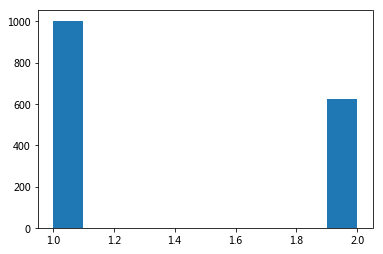

In [747]:
import matplotlib.pyplot as plt
plt.hist(con_expec['con_type_target_price'])
plt.show()

In [748]:
# def type_map(row):
#     if row['con_type'] >= 3:
#         return 1
#     else:
#         return 2
# con_expec = prediction.groupby('ticker_symbol').size().to_frame('con_type').reset_index()
con_expec['con_type_score'] = con_expec['con_type_target_price']


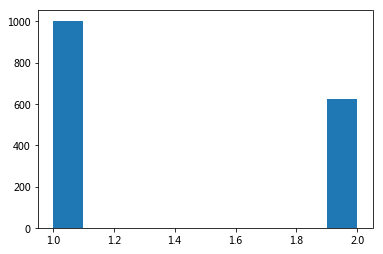

In [749]:
plt.hist(con_expec['con_type_score'])
plt.show()

In [132]:
prediction.head()

,level_0,income_err,profit_err,eps_err,organ_id,ticker_symbol,report_search_id,create_date,into_date,time_year,...,profit_para,eps_para,nan_eps_err,group_count,inf_err,decay_day,decay_day_eps,target_price_nan_sum,decay_sum,decay_eps
0,0,0.006476,0.000775,0.001294,77.0,000001,2099096,2019-03-08,2019-03-08 00:00:00,2019.0,...,1289.831245,772.838231,False,7,0,0.64,494.616468,0,6040.989815,1.285465
1,1,0.013207,0.002713,0.001479,3.0,000001,2101297,2019-03-17,2019-03-17 00:00:00,2019.0,...,368.549425,675.999355,False,7,0,0.64,432.639587,0,6040.989815,1.183118
2,2,0.137529,0.210331,0.268309,2570.0,000001,2110384,2019-04-24,2019-04-24 00:00:00,2019.0,...,4.754407,3.727045,False,7,0,0.80,2.981636,0,6040.989815,0.008494
3,3,0.012832,0.026523,0.016769,20.0,000001,2110425,2019-04-24,2019-04-24 00:00:00,2018.0,...,37.703654,59.632716,False,7,0,0.80,47.706173,0,6040.989815,0.134250
4,4,0.000738,0.000060,0.002536,30.0,000001,2110528,2019-04-24,2019-04-24 00:00:00,2019.0,...,16535.561331,394.306122,False,7,0,0.80,315.444898,0,6040.989815,0.904928


In [133]:
con_expec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1121 entries, 0 to 1120
Data columns (total 2 columns):
ticker_symbol            1121 non-null object
con_type_target_price    1121 non-null int64
dtypes: int64(1), object(1)
memory usage: 17.6+ KB


In [750]:
con_expec.loc[:,'pred_date'] = pred_date

In [751]:
df = prediction[['ticker_symbol','decay_eps_price']].groupby('ticker_symbol').apply(
    lambda x: x['decay_eps_price'].sum() if not np.isnan(x['decay_eps_price']).all() else np.nan).to_frame("con_target_price").reset_index()
# con_expec['con_type_target_price'] = con_expec.apply(type_map, axis=1)


In [752]:
con_expec = con_expec.merge(df, on='ticker_symbol')

In [753]:
df = prediction[['ticker_symbol','decay_eps_score']].groupby('ticker_symbol').apply(
    lambda x: x['decay_eps_score'].sum() if not np.isnan(x['decay_eps_score']).all() else np.nan).to_frame("con_target_score").reset_index()
# con_expec['con_type_target_price'] = con_expec.apply(type_map, axis=1)


In [754]:
con_expec = con_expec.merge(df, on='ticker_symbol')

In [755]:
con_expec[con_expec.ticker_symbol==ticker]

,ticker_symbol,con_type,con_type_target_price,con_type_score,pred_date,con_target_price,con_target_score
1,000002,25,1,1,2019-05-27,38.565843,0.959292


In [140]:
# for other tickers with target price is nan

In [143]:
# tickers.info()


# 将不在结果中的ticker补齐

In [984]:
tickers.head()

,ticker_symbol,list_date,delist_date,SEC_SHORT_NAME
0,000001,1991-04-03,NaN,平安银行
1,000002,1991-01-29,NaN,万科A
2,000003,1991-07-03,2002-06-14,PT金田A
3,000004,1991-01-14,NaN,国农科技
4,000005,1990-12-10,NaN,世纪星源


In [991]:
alive_ticker_df = tickers.loc[tickers.delist_date.isnull()]

In [993]:
ticker_pred_price = alive_ticker_df[['ticker_symbol']].merge(con_expec,on='ticker_symbol',how='left') 

In [997]:
ticker_pred_price['con_type_target_price'] = ticker_pred_price['con_type_target_price'].fillna(3)

In [998]:
ticker_pred_price['pred_date'] = ticker_pred_price['pred_date'].fillna(pred_date)

In [1001]:
ticker_pred_price['con_type_target_price']=ticker_pred_price['con_type_target_price'].astype(int)

In [999]:
ticker_pred_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3647 entries, 0 to 3646
Data columns (total 4 columns):
ticker_symbol            3647 non-null object
con_type_target_price    3647 non-null float64
pred_date                3647 non-null object
con_target_price         1109 non-null float64
dtypes: float64(2), object(2)
memory usage: 142.5+ KB


In [142]:
# ticker_pred_price

# done calculate price 